In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas_datareader.data as pdr
from cytoolz import sliding_window
import pickle
from itertools import groupby

In [2]:
def test_increasing_value(v):
    if(v>0):
        return 1
    else:
        return 0

def test_decreasing_value(v):
    if(v<0):
        return 1
    else:
        return 0


In [3]:
dict_sectors = {'Basic Materials':'VAW', 'Communication Services':'VOX', 'Consumer Cyclical':'VCR',
       'Consumer Defensive':'VDC', 'Energy':'VDE', 'Financial Services':'VFH', 'Healthcare':'VHT',
       'Industrials':'VIS', 'Real Estate':'VNQ', 'Technology':'VGT', 'Utilities':'VPU', 'error':'error'}

dict_indexes = {'SPTM':'SP1500', 'SPY':'SP500', 'SLY':'SP600', 'MDYG':'SP400','error':'error'}

dict_sectors_reverse = {'VAW':'Basic Materials',
 'VOX':'Communication Services',
 'VCR':'Consumer Cyclical',
 'VDC':'Consumer Defensive',
 'VDE':'Energy',
 'VFH':'Financial Services',
 'VHT':'Healthcare',
 'VIS':'Industrials',
 'VNQ':'Real Estate',
 'VGT':'Technology',
 'VPU':'Utilities',
 'error': 'error'}

In [4]:
def highlight_cells(val):
    color = 'yellow' if val == True else ''
    return 'background-color: {}'.format(color)

In [5]:
si = ['03-31','06-30','09-30','12-31']
               
[start,end, prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted] = pickle.load(open('./data_object.pkl', 'rb'))

prices = prices_df
#prices = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500_Sectors_Indexes_Prices")

In [6]:
#today = datetime.today().strftime('%Y-%m-%d')
today = end

#past = (datetime.strptime(today, '%Y-%m-%d') - relativedelta(months=21)).strftime('%Y-%m-%d')
past = start

In [7]:
indexes_df = pd.DataFrame()

for s in indexes[0].values:
    indexes_df = pd.concat([prices_df[prices_df['Symbol'] == s][['Adj Close']],indexes_df],axis=1)
    
indexes_df.columns = indexes[0].values

indexes_df_qtr_pvt = indexes_df.asfreq('d').interpolate().resample('W').mean().pct_change()

sectors_df = pd.DataFrame()

for s in sectors[0].values:
    sectors_df = pd.concat([prices_df[prices_df['Symbol'] == s][['Adj Close']],sectors_df],axis=1)
    
sectors_df.columns = sectors[0].values

sectors_df_qtr_pvt = sectors_df.asfreq('D').interpolate().resample('W').mean()

combined_indexes_sectors_df = pd.concat([indexes_df_qtr_pvt,sectors_df_qtr_pvt],axis=1)
combined_indexes_sectors_return_pvt_df = combined_indexes_sectors_df.asfreq('d').interpolate().resample('W').mean().pct_change().dropna()

,VOX,VCR,VDC,VDE,VFH,VHT,VIS,VGT,VAW,VNQ,VPU
2017-02-22,96.039925,70.866066,110.636986,127.404724,116.490662,127.735298,56.948162,83.790840,126.059090,129.170135,91.784111
2017-02-23,97.030464,71.234825,109.634109,127.109581,115.664032,128.418106,57.011791,84.122688,126.201569,127.993767,91.590950
2017-02-24,98.333809,71.570053,109.661705,127.366653,116.184166,129.175720,56.593662,83.178223,126.673416,128.567825,91.305801
2017-02-27,97.847244,71.947174,109.560516,127.395203,116.880760,130.064346,56.829998,84.020561,126.076904,128.840744,91.213799
2017-02-28,98.724823,71.452705,109.477692,126.614571,116.109886,129.540573,56.648205,83.697250,126.246033,127.871368,89.907593
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-15,145.539993,89.389999,169.570007,330.410004,166.130005,223.149994,77.639999,114.860001,179.309998,234.580002,95.089996
2022-06-16,142.639999,87.040001,162.750000,315.970001,159.779999,219.509995,75.419998,108.400002,177.660004,222.740005,91.389999
2022-06-17,141.440002,87.699997,162.800003,319.809998,159.809998,220.210007,75.849998,102.349998,177.059998,225.869995,92.860001
2022-06-20,143.322498,88.614998,164.247498,325.870010,161.752495,224.485004,76.952499,106.234999,180.517498,230.047501,93.610001


In [8]:
cli_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CLI.../OECD?contentType=csv&detail=USA&separator=comma&csv-lang=en")
#cli_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CLI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")

In [9]:
bci_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.BCI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")

In [10]:
cci_df = pd.read_csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.CCI.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en")

In [11]:
np.unique(cci_df.LOCATION)

array(['AUS', 'AUT', 'BEL', 'BRA', 'CHE', 'CHL', 'CHN', 'COL', 'CRI',
       'CZE', 'DEU', 'DNK', 'EA19', 'ESP', 'EST', 'FIN', 'FRA', 'G-7',
       'GBR', 'GRC', 'HUN', 'IDN', 'IRL', 'ISR', 'ITA', 'JPN', 'KOR',
       'LTU', 'LUX', 'LVA', 'MEX', 'NLD', 'NZL', 'OECD', 'OECDE', 'POL',
       'PRT', 'RUS', 'SVK', 'SVN', 'SWE', 'TUR', 'USA', 'ZAF'],
      dtype=object)

In [12]:
bci_df_USA = bci_df[bci_df['LOCATION']=='USA']
bci_df_USA.index = bci_df_USA[bci_df_USA['LOCATION']=='USA'].set_index('TIME').index.map(lambda t: datetime.strptime(t,'%Y-%m'))
cci_df_USA = cci_df[cci_df['LOCATION']=='USA']
cci_df_USA.index = cci_df_USA[cci_df_USA['LOCATION']=='USA'].set_index('TIME').index.map(lambda t: datetime.strptime(t,'%Y-%m'))
cli_df_USA = cli_df[cli_df['LOCATION']=='USA']
cli_df_USA.index = cli_df_USA[cli_df_USA['LOCATION']=='USA'].set_index('TIME').index.map(lambda t: datetime.strptime(t,'%Y-%m'))

,SPTM,SPY,SLY,MDYG,VOX,VCR,VDC,VDE,VFH,VHT,VIS,VGT,VAW,VNQ,VPU
2022-04-24,-0.880777,-0.958357,-0.267060,-0.317092,-0.007214,0.004634,-0.001668,-0.025141,-0.001447,-0.015433,-0.009604,0.000006,0.010630,-0.005210,-0.037274
2022-05-01,8.224781,30.407780,0.868366,1.016407,-0.026047,-0.015699,-0.023415,-0.020558,-0.018688,-0.029611,-0.028992,-0.030179,-0.005042,-0.032039,-0.052813
2022-05-08,0.215687,-0.020220,-0.104135,-0.085851,-0.021403,-0.045660,-0.015623,-0.018271,-0.020423,-0.027604,-0.024460,0.015023,-0.018300,-0.048391,-0.029589
2022-05-15,0.437538,0.140347,0.137656,0.140712,-0.006638,-0.052366,-0.024582,-0.037736,-0.025503,-0.020717,-0.025483,0.012810,-0.012379,-0.057718,-0.022982
2022-05-22,-0.433427,-0.574422,-0.234495,-0.252937,0.003878,-0.022493,-0.011152,-0.031234,-0.020944,0.000964,-0.017104,0.017121,-0.030515,-0.048966,-0.011012
2022-05-29,-1.810921,-2.835551,-1.580616,-1.615414,0.023397,0.017742,0.023796,0.011898,0.008117,0.019301,0.025180,0.050086,-0.012835,-0.002478,0.006547
2022-06-05,0.560206,0.259375,0.784354,0.753862,0.015431,0.014917,0.021975,0.027294,0.021714,0.003318,0.024636,0.038697,0.008466,0.035513,0.012533
2022-06-12,-1.186319,-1.139606,-1.513901,-1.473325,-0.014312,-0.021857,-0.011375,-0.011431,-0.002744,-0.018108,-0.019695,0.017785,-0.010601,-0.001897,-0.010000
2022-06-19,11.400383,15.514945,3.983995,4.296942,-0.060999,-0.057529,-0.067489,-0.058090,-0.050637,-0.040180,-0.059235,-0.064617,-0.033084,-0.059751,-0.051936
2022-06-26,-0.341924,-0.309268,-0.514979,-0.485576,-0.040208,-0.026290,-0.048626,-0.024894,-0.033669,-0.013611,-0.028091,-0.069614,-0.011058,-0.028097,-0.026571


1955-01-02    101.522034
1955-01-09    101.574539
1955-01-16    101.656213
1955-01-23    101.737887
1955-01-30    101.819561
                 ...    
2022-04-03     99.840238
2022-04-10     99.835707
2022-04-17     99.831869
2022-04-24     99.828030
2022-05-01     99.824191
Freq: W-SUN, Length: 3514, dtype: float64

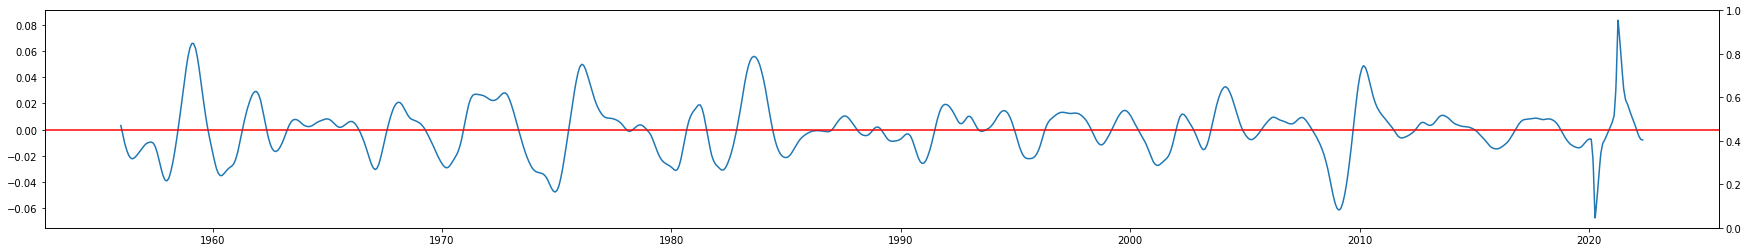

In [13]:
USALOLITONOSTSAM = pdr.DataReader('USALOLITONOSTSAM','fred','1955-01-01',today)-100

USPHCI = pdr.DataReader('USPHCI','fred','1955-01-01',today)
USPHCI_signal = USPHCI.rolling(4).mean()-USPHCI.rolling(12*4).mean()


"""
signal = USALOLITONOSTSAM['USALOLITONOSTSAM']

Recovery = (signal<0)*(signal.pct_change(1)>0)
Expansion = (signal>0)*(signal.pct_change(1)>0)
Slowdown = (signal>0)*(signal.pct_change(1)<0)
Recession = (signal<0)*(signal.pct_change(1)<0)
"""
#combined_leading = pd.concat([cli_df_USA['Value']-100,USALOLITONOSTSAM],axis=1)
combined_leading = pd.concat([cli_df_USA['Value'],USALOLITONOSTSAM+100],axis=1)

#signal = combined_leading.mean(axis=1)
#signal = combined_leading.mean(axis=1).asfreq('d').interpolate().asfreq('q')
#signal = combined_leading.mean(axis=1).asfreq('d').interpolate().resample('W').mean()
modified = combined_leading.mean(axis=1).asfreq('d').interpolate().resample('W').mean()

#QTR_SMA = cli_df_USA['Value'].rolling(3).mean()

fig, ax1 = plt.subplots( figsize=(30,4) )


#plt.plot(signal1)

ax2 = ax1.twinx()

signal = modified.pct_change(52)

ST_SMA = signal.rolling(13*4).mean()
LT_SMA = signal.rolling(52*4).mean()
#signal = ST_SMA - LT_SMA
#signal_ = ST_SMA-LT_SMA

ax1.plot(signal)
#ax2.plot(signal_)

ax1.axhline(y = 0, color = 'r', linestyle = '-')

#troughs
troughs = signal.rolling(52*4).min()
#plt.plot(troughs)
#troughs = trough

#peaks
peaks = signal.rolling(52*4).max()
#plt.plot(peaks)
#peaks = peak

#plt.plot(combined_leading)
#plt.plot(signal_MACD)
#plt.show()

In [14]:
#cli_range_df = cli_df_USA[(cli_df_USA.index<=today) & (cli_df_USA.index>=past)]

In [15]:
#plt.plot(USPHCI.pct_change())

In [16]:
"""
slowdown = (business_cycle['ST_SMA']<business_cycle['ST_SMA'].shift(1))& (expansion==False) & (recovery==False) & (business_cycle['signal']<business_cycle['peak'])# & (business_cycle['signal']!=business_cycle['troughs'])#
np.sum(slowdown)
"""

"\nslowdown = (business_cycle['ST_SMA']<business_cycle['ST_SMA'].shift(1))& (expansion==False) & (recovery==False) & (business_cycle['signal']<business_cycle['peak'])# & (business_cycle['signal']!=business_cycle['troughs'])#\nnp.sum(slowdown)\n"

In [17]:
business_cycle = pd.concat([signal,troughs,peaks,ST_SMA,LT_SMA],axis=1)
business_cycle.columns = ["signal","troughs","peaks","ST_SMA","LT_SMA"]

if(True):
    #expansion = (business_cycle['ST_SMA']>business_cycle['LT_SMA'])&(business_cycle['ST_SMA']>0)
    expansion = (business_cycle['signal']>business_cycle['signal'].shift(1))&(business_cycle['signal']>0)
    #expansion = (business_cycle['signal']==business_cycle['peaks'])&(business_cycle['signal']>0)
    
    #expansion = (business_cycle['ST_SMA'].pct_change()>0)&(business_cycle['signal']>0)
    
    recovery = (business_cycle['signal']>business_cycle['signal'].shift(1))&(business_cycle['signal']<0)
    #recovery = (business_cycle['ST_SMA'].pct_change()>0)&(business_cycle['signal']<0)
    
    #recession = (business_cycle['ST_SMA']>business_cycle['LT_SMA'])&(business_cycle['ST_SMA']<0)
    recession = (business_cycle['signal']<business_cycle['signal'].shift(1))&(business_cycle['signal']<0)
    #recession = (business_cycle['ST_SMA'].pct_change()<0)&(business_cycle['signal']<0)
    slowdown = (business_cycle['signal']<business_cycle['signal'].shift(1))&(business_cycle['signal']>0)
    #slowdown = (business_cycle['signal']<business_cycle['peaks'])&(business_cycle['signal']>0)
    #slowdown = (business_cycle['ST_SMA'].pct_change()<0)&(business_cycle['signal']>0)

if(False):
    expansion = (business_cycle['ST_SMA']>business_cycle['LT_SMA']) #& (business_cycle['signal']==business_cycle['peak'])
    #recovery = (business_cycle['ST_SMA']>business_cycle['ST_SMA'].shift(1)) & (business_cycle['signal']>business_cycle['troughs']) & (business_cycle['ST_SMA']<business_cycle['LT_SMA']) #& (business_cycle['ST_SMA']<business_cycle['LT_SMA'])
    recovery = (expansion==False) & (business_cycle['signal']>business_cycle['troughs'])
    expansion = (expansion) & (recovery==False) 
    #expansion = (business_cycle['ST_SMA']>business_cycle['LT_SMA'])
    #slowdown = (combined['ST_SMA']>combined['LT_SMA']) & (combined['signal']<combined['peak'])

    #slowdown = (business_cycle['ST_SMA']<business_cycle['ST_SMA'].shift(1)) & (expansion==False) & (recovery==False) & (business_cycle['signal']<business_cycle['peak']) & (business_cycle['signal']!=business_cycle['troughs'])
    slowdown = (business_cycle['ST_SMA']<business_cycle['ST_SMA'].shift(1))& (expansion==False) & (recovery==False) & (business_cycle['signal']<business_cycle['peak'])# & (business_cycle['signal']!=business_cycle['troughs'])#
    np.sum(slowdown)
    #recession = (combined['ST_SMA']<combined['LT_SMA']) & (combined['signal']==combined['troughs'])
    #if yesterday's difference less than today's difference
    #recession = (business_cycle['ST_SMA']<business_cycle['LT_SMA']) & (business_cycle['signal']==business_cycle['troughs']) & (business_cycle['signal']<business_cycle['signal'].shift(1)) & (abs(business_cycle['signal'].pct_change())>abs(business_cycle['signal'].pct_change().shift(1)))

    #recession = ((business_cycle['peak']-business_cycle['troughs'])>(business_cycle['peak']-business_cycle['troughs']).shift(1)) & (business_cycle['signal'] < business_cycle['signal'].shift(1)) & (abs(business_cycle['signal'].diff())>(abs(business_cycle['signal'].shift(1).diff()))**2) & (business_cycle['signal']<business_cycle['ST_SMA']) & (((business_cycle['signal']<business_cycle['ST_SMA']) & ((business_cycle['ST_SMA']-business_cycle['signal'])>(((business_cycle['ST_SMA']-business_cycle['signal']).shift(1))))))
    recession = ((business_cycle['signal']==business_cycle['troughs'])&((business_cycle['ST_SMA']-business_cycle['signal'])/(business_cycle['peak']-business_cycle['signal'])>.25)) #\
    """
    &\
    ((business_cycle['signal'].pct_change()/business_cycle['signal'].pct_change().shift(1))>1.5)
    """
    """
    &\
    ((business_cycle['LT_SMA']-business_cycle['ST_SMA'])>(business_cycle['LT_SMA']-business_cycle['ST_SMA']).shift(1))\
    &((business_cycle['ST_SMA']-business_cycle['signal'])>(business_cycle['ST_SMA']-business_cycle['signal']).shift(1))\
    &((business_cycle['peak']-business_cycle['LT_SMA'])>(business_cycle['peak']-business_cycle['LT_SMA']).shift(1))\
    &((business_cycle['peak']-business_cycle['troughs'])>(business_cycle['peak']-business_cycle['troughs']).shift(1))\
    """
    #&(business_cycle['signal'].pct_change()<-.25)

    #& ((business_cycle['peak']-business_cycle['troughs'])>(business_cycle['peak']-business_cycle['troughs']).shift(1)) & (business_cycle['signal'] < business_cycle['signal'].shift(1)) & (abs(business_cycle['signal'].diff())>(abs(business_cycle['signal'].shift(1).diff()))**2) & (business_cycle['signal']<business_cycle['ST_SMA']) & (((business_cycle['signal']<business_cycle['ST_SMA']) & ((business_cycle['ST_SMA']-business_cycle['signal'])>(((business_cycle['ST_SMA']-business_cycle['signal']).shift(1))))))

    #recession = (business_cycle['troughs']<business_cycle['troughs'].shift(1))&(abs(business_cycle['troughs'].pct_change())>abs(business_cycle['troughs'].pct_change()).shift(1))
    #((business_cycle['signal']<business_cycle['ST_SMA'])&(abs(business_cycle['signal']<business_cycle['ST_SMA']))>(abs(business_cycle['LT_SMA']-business_cycle['ST_SMA'])))

    #recession = (business_cycle['ST_SMA']<business_cycle['LT_SMA']) & (business_cycle['signal']<business_cycle['signal'].shift(1)) & (abs(business_cycle['signal'].pct_change())>abs(2*business_cycle['signal'].pct_change().shift(1))) & (business_cycle['ST_SMA']<business_cycle['ST_SMA'].shift(1)) & (abs(business_cycle['ST_SMA'].pct_change())>abs(business_cycle['ST_SMA'].pct_change().shift(1))) \
    #& ((business_cycle['peak']-business_cycle['troughs'])>(business_cycle['peak']-business_cycle['troughs']).shift(1))
    slowdown = (slowdown) & (slowdown!=recession) & (slowdown!=recovery) & (slowdown!=expansion)

business_cycle = pd.concat([business_cycle,recovery,expansion,slowdown,recession],axis=1)
business_cycle = business_cycle.dropna()
business_cycle.columns = [*business_cycle.columns[0:5],'recovery','expansion','slowdown','recession']
#slowdown = combined['ST_SMA']<combined['LT_SMA']
    


In [18]:
"""
#The LEI Index YoY changes are positive and above long-term trends
#Expansion = (cli_df_USA['Value']>LT_SMA) * (ST_SMA.pct_change()>0) * (cli_df_USA['Value']>cli_df_USA['Value'].shift(1))

#***
#Expansion = (signal>LT_SMA) * (ST_SMA.pct_change()>0) * (signal>signal.shift(1))

#Expansion = (signal>LT_SMA) * np.logical_or(((ST_SMA>LT_SMA).values),((ST_SMA.pct_change()>0).values))# * (signal>signal.shift(1))
Expansion =  (signal>signal.shift(1)) * np.logical_or(((ST_SMA>LT_SMA).values),((ST_SMA.pct_change()>0).values))# *
np.sum(Expansion)

#Recovery = (cli_df_USA['Value'] > troughs) * (cli_df_USA['Value']<LT_SMA) * (cli_df_USA['Value']>cli_df_USA['Value'].shift(1))
Recovery = (signal > troughs) * (signal>signal.shift(1)) * (Expansion==0) * (signal<LT_SMA)
np.sum(Recovery)

print(np.sum(Recovery*Expansion))

Declining = ((Recovery!=1)*(Expansion!=1))
print(np.sum(Declining))

###Recession

today_minus_yesterday = signal-signal.shift(1)

yesterday_minus_today = signal.shift(1)-signal

#rapidly declines to a troughs

#today is less than yesterday
#at an accelerating pace OR
    #yesterday was receding
#Recession = ((today_minus_yesterday<0) * ((np.abs(today_minus_yesterday)>np.abs(today_minus_yesterday.shift(1))).values|(today_minus_yesterday.shift(1)<0).values)) # * (signal == troughs))
Recession = ((today_minus_yesterday<0) * ((np.abs(today_minus_yesterday)>np.abs(today_minus_yesterday.shift(1))).values)) * (signal == troughs)

print(np.sum(Recession))

#prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]

Not_recession = (Recession==0)*(Recovery==0)*(Expansion==0)#*(signal<peak)
Slowdown = Not_recession
print(Slowdown)

#Slowdown = (ST_SMA < peaks)
#recession = Recession
#slowdown = Slowdown
#recovery = Recovery
#expansion = Expansion
"""

"\n#The LEI Index YoY changes are positive and above long-term trends\n#Expansion = (cli_df_USA['Value']>LT_SMA) * (ST_SMA.pct_change()>0) * (cli_df_USA['Value']>cli_df_USA['Value'].shift(1))\n\n#***\n#Expansion = (signal>LT_SMA) * (ST_SMA.pct_change()>0) * (signal>signal.shift(1))\n\n#Expansion = (signal>LT_SMA) * np.logical_or(((ST_SMA>LT_SMA).values),((ST_SMA.pct_change()>0).values))# * (signal>signal.shift(1))\nExpansion =  (signal>signal.shift(1)) * np.logical_or(((ST_SMA>LT_SMA).values),((ST_SMA.pct_change()>0).values))# *\nnp.sum(Expansion)\n\n#Recovery = (cli_df_USA['Value'] > troughs) * (cli_df_USA['Value']<LT_SMA) * (cli_df_USA['Value']>cli_df_USA['Value'].shift(1))\nRecovery = (signal > troughs) * (signal>signal.shift(1)) * (Expansion==0) * (signal<LT_SMA)\nnp.sum(Recovery)\n\nprint(np.sum(Recovery*Expansion))\n\nDeclining = ((Recovery!=1)*(Expansion!=1))\nprint(np.sum(Declining))\n\n###Recession\n\ntoday_minus_yesterday = signal-signal.shift(1)\n\nyesterday_minus_today = si

In [19]:
"""
np.sum(\
((business_cycle['LT_SMA']-business_cycle['ST_SMA'])>(business_cycle['LT_SMA']-business_cycle['ST_SMA']).shift(1))\
&((business_cycle['ST_SMA']-business_cycle['signal'])>(business_cycle['ST_SMA']-business_cycle['signal']).shift(1))\
&((business_cycle['peak']-business_cycle['LT_SMA'])>(business_cycle['peak']-business_cycle['LT_SMA']).shift(1))\
&((business_cycle['peak']-business_cycle['troughs'])>(business_cycle['peak']-business_cycle['troughs']).shift(1))\
      )
"""

"\nnp.sum(((business_cycle['LT_SMA']-business_cycle['ST_SMA'])>(business_cycle['LT_SMA']-business_cycle['ST_SMA']).shift(1))&((business_cycle['ST_SMA']-business_cycle['signal'])>(business_cycle['ST_SMA']-business_cycle['signal']).shift(1))&((business_cycle['peak']-business_cycle['LT_SMA'])>(business_cycle['peak']-business_cycle['LT_SMA']).shift(1))&((business_cycle['peak']-business_cycle['troughs'])>(business_cycle['peak']-business_cycle['troughs']).shift(1))      )\n"

In [20]:
#(business_cycle['signal']<business_cycle['ST_SMA']) & (business_cycle['ST_SMA']-business_cycle['signal'])>(2*((business_cycle['ST_SMA']-business_cycle['signal']).shift(1)))

In [21]:
#plt.plot(business_cycle['signal'].pct_change())

In [22]:
#business_cycle['signal'][business_cycle['signal'].index>'2020-01-01'].pct_change().head(30)

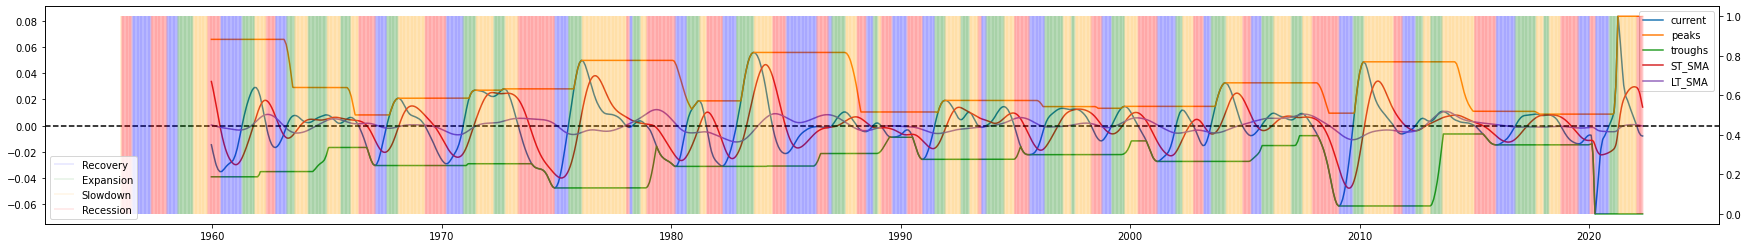

In [23]:
fig, ax1 = plt.subplots( figsize=(30,4) )
#plt.plot(cli_df_USA['Value'])
ax1.plot(business_cycle['signal'])

ax1.plot(business_cycle['peaks'])
ax1.plot(business_cycle['troughs'])
ax1.plot(business_cycle['ST_SMA'])
ax1.plot(business_cycle['LT_SMA'])
ax1.axhline(y = 0, color = 'black', linestyle = '--')
ax1.legend(['current','peaks','troughs','ST_SMA','LT_SMA'],loc=1)
#plt.legend(['current','ST_SMA','LT_SMA'],loc=1)

ax2 = ax1.twinx()

trans = mtransforms.blended_transform_factory(ax2.transData, ax2.transAxes)

ax2.vlines((recovery == 1).index[(recovery == 1).values],color='blue', alpha=0.1, ymin=0, ymax=1, colors=None, linestyles='solid',label='Recovery')
ax2.vlines((expansion == 1).index[(expansion == 1).values],color='green', alpha=0.1, ymin=0, ymax=1, colors=None, linestyles='solid',label='Expansion')
ax2.vlines((slowdown == 1).index[(slowdown == 1).values],color='orange', alpha=0.1, ymin=0, ymax=1, colors=None, linestyles='solid',label='Slowdown')
ax2.vlines((recession == 1).index[(recession == 1).values],color='red', alpha=0.1, ymin=0, ymax=1, colors=None, linestyles='solid',label='Recession')

ax2.legend(['Recovery','Expansion','Slowdown','Recession'],loc=3)
plt.show()

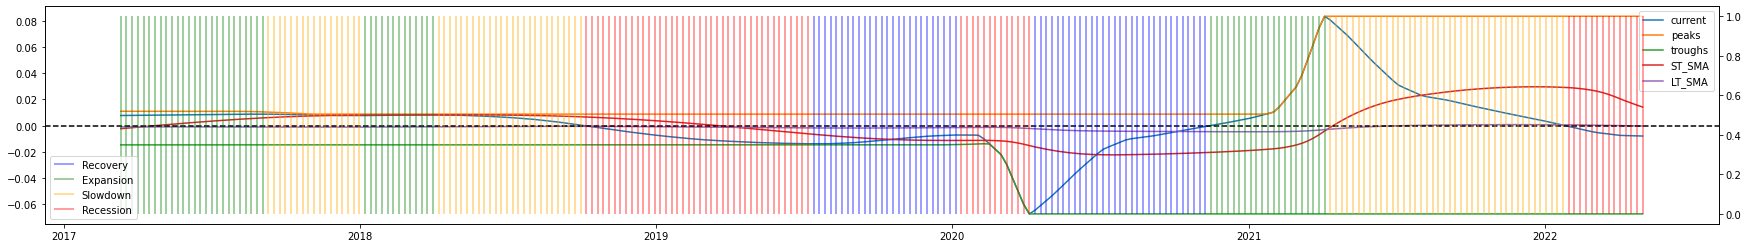

In [24]:
fig, ax1 = plt.subplots( figsize=(30,4) )
#plt.plot(cli_df_USA['Value'])
ax1.plot(business_cycle['signal'].reindex(combined_indexes_sectors_return_pvt_df.index))

ax1.plot(business_cycle['peaks'].reindex(combined_indexes_sectors_return_pvt_df.index))
ax1.plot(business_cycle['troughs'].reindex(combined_indexes_sectors_return_pvt_df.index))
ax1.plot(business_cycle['ST_SMA'].reindex(combined_indexes_sectors_return_pvt_df.index))
ax1.plot(business_cycle['LT_SMA'].reindex(combined_indexes_sectors_return_pvt_df.index))
ax1.axhline(y = 0, color = 'black', linestyle = '--')
ax1.legend(['current','peaks','troughs','ST_SMA','LT_SMA'],loc=1)
#plt.legend(['current','ST_SMA','LT_SMA'],loc=1)

ax2 = ax1.twinx()

trans = mtransforms.blended_transform_factory(ax2.transData, ax2.transAxes)

"""
ax2.fill_between(business_cycle.index, 0, 1, where=Recovery['USPHCI'].reindex(business_cycle.index) == 1,facecolor='blue', alpha=0.5, transform=trans)
ax2.fill_between(business_cycle.index, 0, 1, where=Expansion['USPHCI'].reindex(business_cycle.index) == 1,facecolor='orange', alpha=0.5, transform=trans)
ax2.fill_between(business_cycle.index, 0, 1, where=Slowdown['USPHCI'].reindex(business_cycle.index) == 1,facecolor='green', alpha=0.5, transform=trans)
ax2.fill_between(business_cycle.index, 0, 1, where=Recession['USPHCI'].reindex(business_cycle.index) == 1,facecolor='red', alpha=0.5, transform=trans)
"""   
 
ax2.vlines((recovery.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).index[(recovery.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).values],color='blue', alpha=0.5, ymin=0, ymax=1, colors=None, linestyles='solid',label='Recovery')
ax2.vlines((expansion.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).index[(expansion.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).values],color='green', alpha=0.5, ymin=0, ymax=1, colors=None, linestyles='solid',label='Expansion')
ax2.vlines((slowdown.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).index[(slowdown.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).values],color='orange', alpha=0.5, ymin=0, ymax=1, colors=None, linestyles='solid',label='Slowdown')
ax2.vlines((recession.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).index[(recession.reindex(combined_indexes_sectors_return_pvt_df.index) == 1).values],color='red', alpha=0.5, ymin=0, ymax=1, colors=None, linestyles='solid',label='Recession')

ax2.legend(['Recovery','Expansion','Slowdown','Recession'],loc=3)
plt.show()

,signal,troughs,peaks,ST_SMA,LT_SMA,recovery,expansion,slowdown,recession
1959-12-20,-0.014589,-0.039025,0.065888,0.033706,0.000506,False,False,False,True
1959-12-27,-0.016237,-0.039025,0.065888,0.032227,0.000413,False,False,False,True
1960-01-03,-0.017859,-0.039025,0.065888,0.030690,0.000318,False,False,False,True
1960-01-10,-0.019345,-0.039025,0.065888,0.029107,0.000224,False,False,False,True
1960-01-17,-0.020809,-0.039025,0.065888,0.027480,0.000130,False,False,False,True
...,...,...,...,...,...,...,...,...,...
2022-04-03,-0.007407,-0.067361,0.083533,0.020555,0.000044,False,False,False,True
2022-04-10,-0.007573,-0.067361,0.083533,0.018858,-0.000031,False,False,False,True
2022-04-17,-0.007683,-0.067361,0.083533,0.017236,-0.000107,False,False,False,True
2022-04-24,-0.007793,-0.067361,0.083533,0.015685,-0.000183,False,False,False,True


,SPTM,SPY,SLY,MDYG,VOX,VCR,VDC,VDE,VFH,VHT,VIS,VGT,VAW,VNQ,VPU
2017-03-12,-4.315757,2.854574,-0.860680,-1.104889,-0.002839,-0.023553,-0.006222,0.002287,-0.002629,0.005726,0.000900,-0.009295,-0.002782,-0.001428,-0.020972
2017-03-19,-0.710540,-0.733298,-0.525292,-0.365216,0.000165,-0.014524,-0.000091,0.006010,-0.003573,0.001263,-0.004114,-0.012939,0.002027,0.004079,-0.002007
2017-03-26,2.034856,0.604540,-14.688727,12.402821,0.010027,0.003986,-0.001353,0.000280,-0.007516,-0.006777,-0.023287,-0.009423,0.002015,-0.000921,0.000302
2017-04-02,-0.612614,-0.785598,-0.570334,-0.819232,0.003075,0.005414,-0.000111,0.001794,-0.002941,-0.004732,-0.013911,0.003117,-0.001958,0.003971,-0.007262
2017-04-09,-1.639510,0.075606,-1.740832,-3.141043,-0.000126,0.010772,0.004583,0.000977,0.002893,-0.001223,-0.001172,0.013035,-0.001401,0.004552,0.006924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-29,-1.810921,-2.835551,-1.580616,-1.615414,0.023397,0.017742,0.023796,0.011898,0.008117,0.019301,0.025180,0.050086,-0.012835,-0.002478,0.006547
2022-06-05,0.560206,0.259375,0.784354,0.753862,0.015431,0.014917,0.021975,0.027294,0.021714,0.003318,0.024636,0.038697,0.008466,0.035513,0.012533
2022-06-12,-1.186319,-1.139606,-1.513901,-1.473325,-0.014312,-0.021857,-0.011375,-0.011431,-0.002744,-0.018108,-0.019695,0.017785,-0.010601,-0.001897,-0.010000
2022-06-19,11.400383,15.514945,3.983995,4.296942,-0.060999,-0.057529,-0.067489,-0.058090,-0.050637,-0.040180,-0.059235,-0.064617,-0.033084,-0.059751,-0.051936


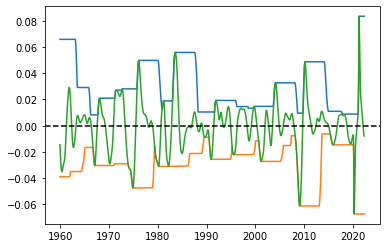

In [25]:
plt.plot(business_cycle[['peaks','troughs']])
plt.plot(business_cycle[['signal']])
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.show()

In [26]:
np.sum(business_cycle.iloc[:,-4:])

recovery     705
expansion    774
slowdown     970
recession    806
dtype: int64

In [27]:
np.sum(np.sum(business_cycle.iloc[:,-4:]))

3255

In [28]:
#Slowdown = (ST_SMA < peak)
#np.sum(Slowdown)

In [29]:
"""
Slowdown = (ST_SMA.pct_change()<0) * (cli_df_USA['Value']<peaks)# (ST_SMA<LT_SMA)
Slowdown = (signal.pct_change()<0) * (signal<peak)# (ST_SMA<LT_SMA)
np.sum(Slowdown)
"""

"\nSlowdown = (ST_SMA.pct_change()<0) * (cli_df_USA['Value']<peaks)# (ST_SMA<LT_SMA)\nSlowdown = (signal.pct_change()<0) * (signal<peak)# (ST_SMA<LT_SMA)\nnp.sum(Slowdown)\n"

In [30]:
#plt.plot(prior_recession * Slowdown['USPHCI'])

In [31]:
"""
print(np.sum(Slowdown))

while (np.sum(prior_recession * Slowdown['USPHCI'])>0):
     
    positions = prior_recession * Slowdown['USPHCI']
    
    #print(np.where(positions))
    
    Recession.iloc[positions] = True
    Slowdown.iloc[positions] = False

    prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]
    Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<peak)
    #positions = np.intersect1d(prior_recession,Slowdown)
    #Recession.iloc[positions] = True
    #Slowdown.iloc[positions] = False
    #prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]
    #Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<peak)
    
    
    
    #print(np.sum(Slowdown))

    
"""

"\nprint(np.sum(Slowdown))\n\nwhile (np.sum(prior_recession * Slowdown['USPHCI'])>0):\n     \n    positions = prior_recession * Slowdown['USPHCI']\n    \n    #print(np.where(positions))\n    \n    Recession.iloc[positions] = True\n    Slowdown.iloc[positions] = False\n\n    prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]\n    Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<peak)\n    #positions = np.intersect1d(prior_recession,Slowdown)\n    #Recession.iloc[positions] = True\n    #Slowdown.iloc[positions] = False\n    #prior_recession = [1 if a[0] else 0 for a in (Recession.shift(1)==1).values]\n    #Slowdown = (Recession==0)*(Recovery==0)*(Expansion==0)*(signal<peak)\n    \n    \n    \n    #print(np.sum(Slowdown))\n\n    \n"

In [32]:
"""
list1 = [-1, -1, 1, 1, 1, -1, 1]
count_dups = [sum(1 for _ in group) for _, group in groupby(list1)]
print(count_dups)
"""

#business_cycle = pd.concat([signal,Recovery,Expansion,Slowdown,Recession],axis=1)
#business_cycle.columns=['Leading','Recovery','Expansion','Slowdown','Recession']
#business_cycle = business_cycle.reindex(peak.dropna().index).dropna()

"""
for c_ in range(1,len(business_cycle.iloc[:,1:].columns)+1):
    c = business_cycle.iloc[:,1:].columns[c_-1]
    business_cycle[c][business_cycle[c]==True] = c_
    business_cycle[c][business_cycle[c]==False] = np.nan

repeats = business_cycle.iloc[:,1:].bfill(axis=1).iloc[:, 0]

#list1 = [-1, -1, 1, 1, 1, -1, 1]
count_dups = [sum(1 for _ in group) for _, group in groupby(repeats)]
print(count_dups)

"""

'\nfor c_ in range(1,len(business_cycle.iloc[:,1:].columns)+1):\n    c = business_cycle.iloc[:,1:].columns[c_-1]\n    business_cycle[c][business_cycle[c]==True] = c_\n    business_cycle[c][business_cycle[c]==False] = np.nan\n\nrepeats = business_cycle.iloc[:,1:].bfill(axis=1).iloc[:, 0]\n\n#list1 = [-1, -1, 1, 1, 1, -1, 1]\ncount_dups = [sum(1 for _ in group) for _, group in groupby(repeats)]\nprint(count_dups)\n\n'

In [33]:
"""
iter = 0
values = []
iterator=0
for c_ in range(0,len(count_dups)):
    c = count_dups[c_]
    #values.append()
    #c_* len(iterator)
    iterator = iterator + c - 1
    values.append(repeats[c_+iterator])
    
values_df = pd.DataFrame(values)

values_df[(values_df==3)*(values_df.shift(1)==4)] = 4
"""

'\niter = 0\nvalues = []\niterator=0\nfor c_ in range(0,len(count_dups)):\n    c = count_dups[c_]\n    #values.append()\n    #c_* len(iterator)\n    iterator = iterator + c - 1\n    values.append(repeats[c_+iterator])\n    \nvalues_df = pd.DataFrame(values)\n\nvalues_df[(values_df==3)*(values_df.shift(1)==4)] = 4\n'

In [34]:
"""
fig, ax1 = plt.subplots( figsize=(30,4) )
plt.plot(recession.reindex(combined_indexes_sectors_return_pvt_df.index))
#plt.fill_between(recession.reindex(combined_indexes_sectors_return_pvt_df.index), 0, 1, where=recession.reindex(combined_indexes_sectors_return_pvt_df.index),
    #facecolor='blue', alpha=0.5, transform=trans)
#plt.legend(loc=1)
#plt.legend(loc=3)
plt.show()
"""

"\nfig, ax1 = plt.subplots( figsize=(30,4) )\nplt.plot(recession.reindex(combined_indexes_sectors_return_pvt_df.index))\n#plt.fill_between(recession.reindex(combined_indexes_sectors_return_pvt_df.index), 0, 1, where=recession.reindex(combined_indexes_sectors_return_pvt_df.index),\n    #facecolor='blue', alpha=0.5, transform=trans)\n#plt.legend(loc=1)\n#plt.legend(loc=3)\nplt.show()\n"

In [35]:
#business_cycle.reindex(combined_indexes_sectors_return_pvt_df.index).style.applymap(highlight_cells)

In [50]:
business_cycles_sectors_indexes = pd.concat([business_cycle,combined_indexes_sectors_return_pvt_df],axis=1).dropna()

In [36]:
#business_cycle.reindex(combined_indexes_sectors_return_pvt_df.index).iloc[:,1:].sum(axis=1).max()

1.0466520113937503

In [38]:
#business_cycle.reindex('troughs'.index).iloc[:,1:].sum(axis=0)

In [ ]:
#today_minus_yesterday.map(lambda t: test_decreasing_value(t))

In [52]:
business_cycles_sectors_indexes

,signal,troughs,peaks,ST_SMA,LT_SMA,recovery,expansion,slowdown,recession,SPTM,...,VCR,VDC,VDE,VFH,VHT,VIS,VGT,VAW,VNQ,VPU
2017-03-12,0.007766,-0.014657,0.010991,-0.002318,-0.000981,False,True,False,False,-4.315757,...,-0.023553,-0.006222,0.002287,-0.002629,0.005726,0.000900,-0.009295,-0.002782,-0.001428,-0.020972
2017-03-19,0.007805,-0.014657,0.010991,-0.001921,-0.000966,False,True,False,False,-0.710540,...,-0.014524,-0.000091,0.006010,-0.003573,0.001263,-0.004114,-0.012939,0.002027,0.004079,-0.002007
2017-03-26,0.007844,-0.014657,0.010991,-0.001528,-0.000953,False,True,False,False,2.034856,...,0.003986,-0.001353,0.000280,-0.007516,-0.006777,-0.023287,-0.009423,0.002015,-0.000921,0.000302
2017-04-02,0.007882,-0.014657,0.010991,-0.001139,-0.000941,False,True,False,False,-0.612614,...,0.005414,-0.000111,0.001794,-0.002941,-0.004732,-0.013911,0.003117,-0.001958,0.003971,-0.007262
2017-04-09,0.007910,-0.014657,0.010991,-0.000754,-0.000931,False,True,False,False,-1.639510,...,0.010772,0.004583,0.000977,0.002893,-0.001223,-0.001172,0.013035,-0.001401,0.004552,0.006924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-03,-0.007407,-0.067361,0.083533,0.020555,0.000044,False,False,False,True,-0.578489,...,0.022858,0.020837,0.031068,0.006302,0.012880,0.001885,0.021162,0.017239,0.025743,0.023111
2022-04-10,-0.007573,-0.067361,0.083533,0.018858,-0.000031,False,False,False,True,-2.339182,...,0.015509,-0.003710,-0.014550,-0.019693,0.014279,-0.021362,0.003009,0.019380,-0.012045,-0.004431
2022-04-17,-0.007683,-0.067361,0.083533,0.017236,-0.000107,False,False,False,True,0.226389,...,-0.004868,-0.000983,-0.040917,-0.018575,-0.001304,-0.021486,0.017755,0.014005,-0.022933,-0.025165
2022-04-24,-0.007793,-0.067361,0.083533,0.015685,-0.000183,False,False,False,True,-0.880777,...,0.004634,-0.001668,-0.025141,-0.001447,-0.015433,-0.009604,0.000006,0.010630,-0.005210,-0.037274


In [53]:
np.sum(business_cycles_sectors_indexes.reindex(business_cycles_sectors_indexes.index).iloc[:,5:9].sum(axis=0))

269